In [26]:
import pandas as pd
from IPython.display import display
import geopandas as gpd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#create an table where all the available data for the map is in
#the table should have 352 rows, because in 2021 the Netherlands had 352 municipalities
urban_level = pd.read_csv("Regionale_kerncijfers_Nederland_2021_GOED.csv", sep=";", header=4)
urban_level.drop(columns=["Perioden"], inplace=True) 

urban_level.rename(columns={"Regio's": "Municipality"}, inplace=True)
urban_level.rename(columns={"per km²": "Adresses per km²"}, inplace=True)

urban_level = urban_level.dropna(subset=["Adresses per km²"]) 

urban_level["Municipality"] = urban_level['Municipality'].str.replace(r"\s*\(gemeente\)", "", regex=True)

#Urbanisation level according to the CBS (zie website van CBS)
def urbanisation_level(per_km2):
    if per_km2 >= 2500:
        niveau = "Very Highly Urban"
    elif 1500 <= per_km2 < 2500:
        niveau = "Highly Urban"
    elif 1000 <= per_km2 < 1500:
        niveau = "Moderately Urban"
    elif 500 <= per_km2 < 1000:
        niveau = "Little Urban"
    else:
        niveau = "Non-Urban"
    return niveau

urban_level["Urbanisation Level"] = urban_level["Adresses per km²"].apply(urbanisation_level)

display(urban_level)


,Municipality,Adresses per km²,Urbanisation Level
0,Aa en Hunze,281.0,Non-Urban
2,Aalsmeer,936.0,Little Urban
3,Aalten,774.0,Little Urban
7,Achtkarspelen,429.0,Non-Urban
9,Alblasserdam,1527.0,Highly Urban
...,...,...,...
720,Zundert,565.0,Little Urban
721,Zutphen,1658.0,Highly Urban
722,Zwartewaterland,725.0,Little Urban
725,Zwijndrecht,2091.0,Highly Urban


In [3]:
    #omdat de namen van allebei de databases niet helemaal overeen komen:
    #wordt het een beetje aangepast in de eerste database zodat het overeenkomt met geometrische data
    urban_level["Municipality"] = urban_level["Municipality"].str.replace(r"\s*\(gemeente\)", "", regex=True)
    urban_level["Municipality"] = urban_level["Municipality"].str.replace(r"\s*\(Z.\)", "", regex=True)
    urban_level["Municipality"] = urban_level["Municipality"].str.replace(r"\s*\(O.\)", "", regex=True)
    urban_level["Municipality"] = urban_level["Municipality"].str.replace(r"\s*\(ZH.\)", "", regex=True)

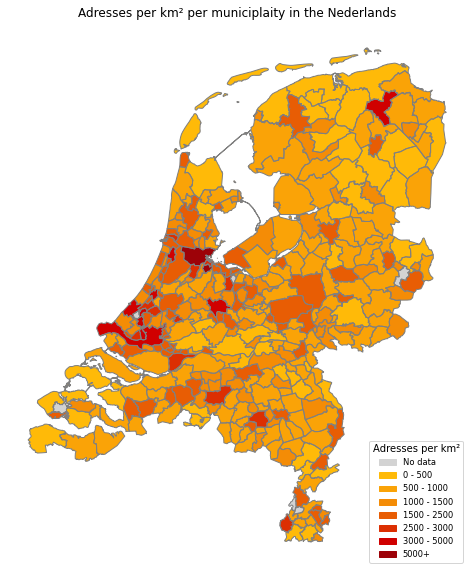

In [28]:
# WFS-URL en parameters
wfs_url = "https://service.pdok.nl/cbs/gebiedsindelingen/2021/wfs/v1_0"
params = dict(service="WFS", version="1.0.0", request="GetFeature", typename="gemeente_gegeneraliseerd", outputFormat="json")
response = requests.get(wfs_url, params=params)

gemeenten_gdf = gpd.read_file(BytesIO(response.content))
gemeenten_gdf.rename(columns={"statnaam": "Municipality"}, inplace=True)

merged = gemeenten_gdf.merge(urban_level, on="Municipality", how="left")
merged["Adresses per km²"].fillna(0, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax, linewidth=1, color="grey")

#kleurtjes
merged["Color"] = pd.cut(merged["Adresses per km²"],
                         bins=[-1, 0, 500, 1000, 1500, 2500, 3000, 5000, 10000],
                         labels=["No data", "0 - 500", "500 - 1000", "1000 - 1500", 
                                 "1500 - 2500", "2500 - 3000", "3000 - 5000", "5000+"])
merged["Color"].fillna("No data", inplace=True)
adressen_colors = {"No data": "lightgrey","0 - 500": "#ffba08","500 - 1000": "#faa307",
                   "1000 - 1500": "#f48c06","1500 - 2500": "#e85d04","2500 - 3000": "#dc2f02","3000 - 5000": "#d00000","5000+": "#9d0208"}
merged.plot(color=merged["Color"].map(adressen_colors), ax=ax,
            missing_kwds={"color": "lightgrey", "label": "No data"})

#opmaak
ax.set_title("Adresses per km² per municiplaity in the Nederlands")
plt.axis("off")  # Verberg de assen
patches = [mpatches.Patch(color=color, label=label) for label, color in adressen_colors.items()]
ax.legend(handles=patches, title="Adresses per km²", loc="lower right", fontsize="small", title_fontsize="medium")

plt.show()




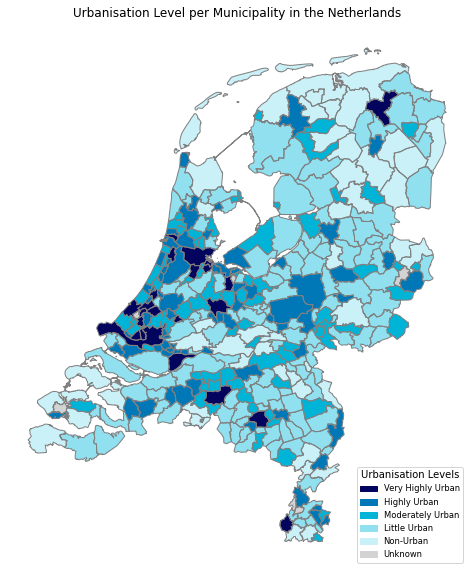

In [30]:
# Merge met de urban_level data
merged = gemeenten_gdf.merge(urban_level, on="Municipality", how="left")
merged["Urbanisation Level"].fillna("Unknown", inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax, linewidth=1, color="grey") 

# Mooie kleurtjes
urbanisation_colors = {"Very Highly Urban": "#03045e", "Highly Urban": "#0077b6","Moderately Urban": "#00b4d8", "Little Urban": "#90e0ef",
                       "Non-Urban": "#caf0f8","Unknown": "lightgrey"}
merged.plot(color=merged["Urbanisation Level"].map(urbanisation_colors), ax=ax,
            missing_kwds={"color": "lightgrey", "label": "Geen gegevens"})
       
ax.set_title("Urbanisation Level per Municipality in the Netherlands")
plt.axis("off")

# Legenda
patches = [mpatches.Patch(color=urbanisation_colors[level], label=level) for level in urbanisation_colors.keys()]
ax.legend(handles=patches, title="Urbanisation Levels", loc='lower right', fontsize='small', title_fontsize='medium')

plt.show()



In [60]:
charging_points = pd.read_excel("paal.xlsx", skiprows=1, index_col=[0])
charging_points = charging_points.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8","Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])
charging_points = charging_points.drop(index=["Drenthe", "Flevoland", "Friesland", "Gelderland", "Limburg", "Noord-Brabant", "Noord-Holland", "Overijssel", "Zeeland", "Zuid-Holland", "Eindtotaal"])
charging_points.sort_index(inplace=True)

print(charging_points.columns)
charging_points.index = charging_points.index.str.replace("Den Haag", "'s-Gravenhage")

#HIER KOMT HEEL VEEL HARDCODE JOEEE
# Verwijder rij groningen en utrecht (gemeentes)
charging_points = charging_points[~((charging_points.index == "Groningen") & (charging_points["Totaal Aantal (Totaal)"] == 16472))]
charging_points = charging_points[~((charging_points.index == "Utrecht") & (charging_points["Totaal Aantal (Totaal)"] == 103350))]

#database gebruikt de naam Maashorst voor uden en landerd, deze zijn in op 1 jan 2022 gefuseerd. 
#de data komt wel uit 2021, 
maashorst_value = charging_points.loc["Maashorst", "Totaal Aantal (Totaal)"] / 2
charging_points.loc["Landerd"] = maashorst_value
charging_points.loc["Uden"] = maashorst_value

#land van cuijk is op 1 januari 2022 gefusseerd van Boxmeer, cuijk, sint anthonis, mill en sint hubert & grave.
land_van_cuijk_value = charging_points.loc["Land van Cuijk", "Totaal Aantal (Totaal)"] /5
charging_points.loc["Boxmeer"] = land_van_cuijk_value
charging_points.loc["Cuijk"] = land_van_cuijk_value
charging_points.loc["Sint Anthonis"] = land_van_cuijk_value
charging_points.loc["Mill en Sint Hubert"] = land_van_cuijk_value 
charging_points.loc["Grave"] = land_van_cuijk_value

#beemster is op 1 jan 2022 gefusseerd met gemeente purmerend
purmerend_value = charging_points.loc["Purmerend", "Totaal Aantal (Totaal)"] / 2
charging_points.loc["Beemster"] = purmerend_value
charging_points.loc["Purmerend"] = purmerend_value

#langedijk en heerhugowaard zjin op 1 jan 2022 gefusseerd tot dijk en waard
dijk_en_waard_value = charging_points.loc["Dijk en Waard" , "Totaal Aantal (Totaal)"] /2
charging_points.loc["Langedijk"] = dijk_en_waard_value
charging_points.loc["Heerhugowaard"] = dijk_en_waard_value

#westvoorne, brielle en hellevoetsluis zjin op 1 jan 2023 gefusseerd tot Voorne aan Zee
voorne_aan_zee_value = charging_points.loc["Voorne aan Zee", "Totaal Aantal (Totaal)"] /3
charging_points.loc["Westvoorne"] = voorne_aan_zee_value
charging_points.loc["Brielle"] = voorne_aan_zee_value
charging_points.loc["Hellevoetsluis"] = voorne_aan_zee_value

#vorige waardes verwijderen(voor fusering)
charging_points = charging_points.drop(index=["Land van Cuijk", "Dijk en Waard", "Voorne aan Zee", "Maashorst"])

def amount_of_chargingpoints(value):
    if value < 1000:
        level = "low"
    elif value < 5000:
        level = "medium"
    elif value < 10000:
        level = "high"
    else:
        level = "very high"
    return level
    
charging_points["Category of charging points"] = charging_points["Totaal Aantal (Totaal)"].apply(amount_of_chargingpoints)

display(charging_points)

Index(['Publiek', 'Semi-publiek', 'Totaal Aantal (Totaal)'], dtype='object')


,Publiek,Semi-publiek,Totaal Aantal (Totaal),Category of charging points
's-Hertogenbosch,6584,5705,12539.0,very high
Aa en Hunze,86,193,279.0,low
Aalsmeer,1933,1161,3094.0,medium
Aalten,332,139,471.0,low
Achtkarspelen,160,71,231.0,low
...,...,...,...,...
Langedijk,1681.0,1681.0,1681.0,medium
Heerhugowaard,1681.0,1681.0,1681.0,medium
Westvoorne,1272.0,1272.0,1272.0,medium
Brielle,1272.0,1272.0,1272.0,medium


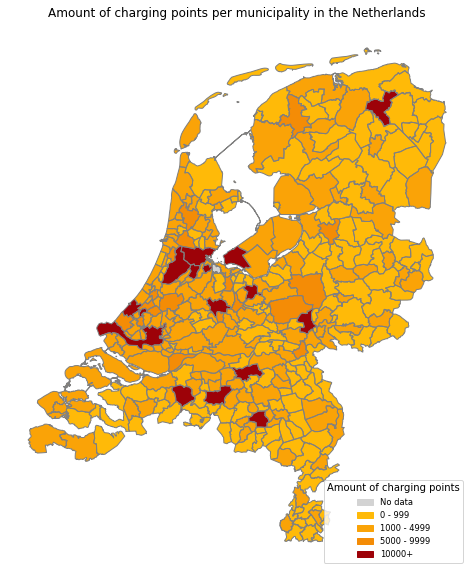

In [47]:
wfs_url = "https://service.pdok.nl/cbs/gebiedsindelingen/2021/wfs/v1_0"
params = dict(service='WFS', version='1.0.0', request='GetFeature', typename='gemeente_gegeneraliseerd', outputFormat='json')
response = requests.get(wfs_url, params=params)

# Laad de gemeentelijke gegevens in een GeoDataFrame
gemeenten_gdf = gpd.read_file(BytesIO(response.content))
gemeenten_gdf.rename(columns={"statnaam": "Municipality"}, inplace=True)

merged = gemeenten_gdf.merge(charging_points, left_on="Municipality", right_index=True, how="left")
merged["Totaal Aantal (Totaal)"].fillna(0, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax, linewidth=1, color="grey")

#kleurtjes
merged["Color"] = pd.cut(merged["Totaal Aantal (Totaal)"],
                         bins=[-1, 0, 999, 4999, 9999, float("inf")],
                         labels=["No data", "0 - 999", "1000 - 4999", "5000 - 9999", "10000+"])
charging_colors = {"No data": "lightgrey", "0 - 999": "#ffba08", "1000 - 4999": "#faa307", "5000 - 9999": "#f48c06", "10000+": "#9d0208"}
merged.plot(color=merged["Color"].map(charging_colors), ax=ax,
            missing_kwds={"color": "lightgrey", "label": "No data"})

#opmaak
ax.set_title("Amount of charging points per municipality in the Netherlands")
plt.axis("off")  # Verberg de assen
patches = [mpatches.Patch(color=color, label=label) for label, color in charging_colors.items()]
ax.legend(handles=patches, title="Amount of charging points", loc="lower right", fontsize="small", title_fontsize="medium")

plt.show()


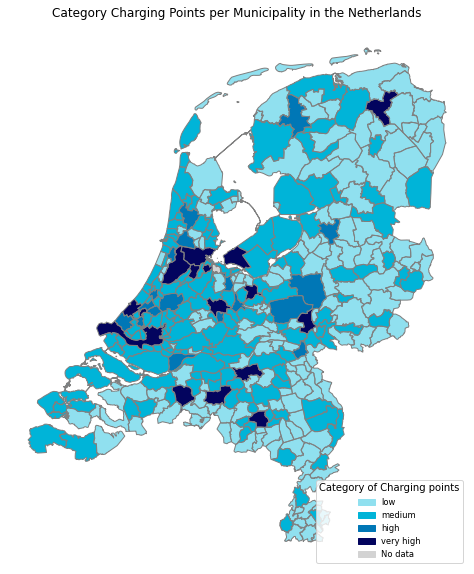

In [59]:
# Kleurenschema voor de oplaadpunten
merged["Color"] = merged["Category of charging points"].map(charging_colors)
merged["Color"].fillna("lightgrey", inplace=True) 

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax, linewidth=1, color="grey") 

#kleurtjes
charging_colors = {"low": "#90e0ef", "medium": "#00b4d8", "high": "#0077b6", "very high": "#03045e", 
                   "No data": "lightgrey"}
merged.plot(color=merged["Color"], ax=ax, missing_kwds={"color": "lightgrey", "label": "No data"})

#opmaak
ax.set_title("Category Charging Points per Municipality in the Netherlands")
plt.axis("off")
patches = [mpatches.Patch(color=color, label=label) for label, color in charging_colors.items()]
ax.legend(handles=patches, title="Category of Charging points", loc="lower right", fontsize="small", title_fontsize="medium")

plt.show()


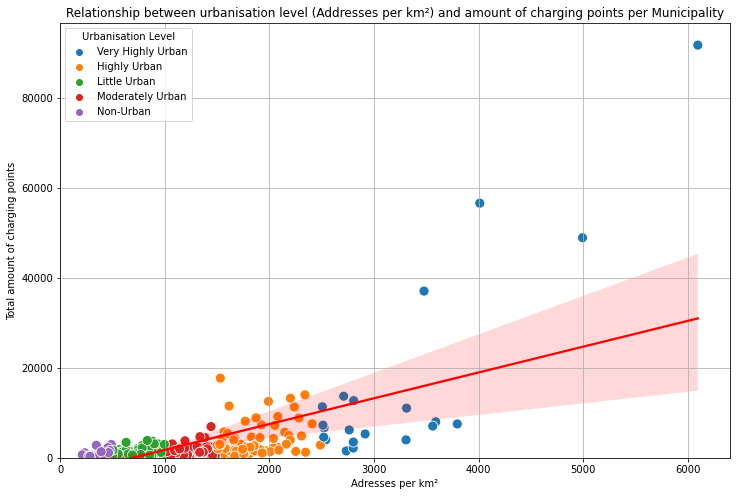

In [58]:
import seaborn as sns
# Merge met de urban_level data
merged = gemeenten_gdf.merge(urban_level, on="Municipality", how="left")
merged["Adresses per km²"].fillna(0, inplace=True)

charging_points.sort_index(inplace=True)

# Merge met de charging_points data
merged = merged.merge(charging_points, left_on="Municipality", right_index=True, how="left")
merged["Totaal Aantal (Totaal)"].fillna(0, inplace=True)

# Begin de visualisatie
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged, x="Adresses per km²", y="Totaal Aantal (Totaal)", hue="Urbanisation Level", s=100)
sns.regplot(data=merged, x="Adresses per km²", y="Totaal Aantal (Totaal)", scatter=False, color="red", line_kws={"label": "Regressielijn"})
plt.title("Relationship between urbanisation level (Addresses per km²) and amount of charging points per Municipality")
plt.xlabel("Adresses per km²")
plt.ylabel("Total amount of charging points")
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid()
plt.legend(title="Urbanisation Level")
plt.show()


In [ ]:
#TOT HIER JOEEEEEEEEJJ


In [18]:
import plotly.graph_objects as go
import statsmodels.api as sm

# Prepare data for regression line
X = merged['Adresses per km²']
y = merged['Totaal Aantal (Totaal)']
X = sm.add_constant(X)  # Voeg een constante toe voor de intercept
model = sm.OLS(y, X).fit()
merged['Predicted'] = model.predict(X)

# Filter voor positieve waarden om regressielijn te plotten
filtered_data = merged[merged['Predicted'] > 0]

# Create scatter plot
fig = go.Figure()

# Add scatter points with municipality names as hover text
fig.add_trace(go.Scatter(
    x=merged['Adresses per km²'],
    y=merged['Totaal Aantal (Totaal)'],
    mode='markers',
    marker=dict(color=merged['Urbanisation Level'].astype('category').cat.codes, size=10),
    text=merged['Municipality'],  # Show municipality name on hover
    hoverinfo='text',  # Specify what to show on hover
    name='Data Points'
))

# Add regression line
fig.add_trace(go.Scatter(
    x=filtered_data['Adresses per km²'],
    y=filtered_data['Predicted'],
    mode='lines',
    line=dict(color='red', width=2),
    name='Regressielijn'
))

# Update layout
fig.update_layout(
    title='Relatie tussen Stedelijkheid (Adressen per km²) en Aantal Laadpalen per Gemeente',
    xaxis_title='Adressen per km²',
    yaxis_title='Totaal Aantal Laadpalen',
    legend_title='Stedelijkheid Niveau',
    template='plotly_white'
)

# Show plot
fig.show()



In [ ]:
#ANDERE OPTIES JOEEEE
aantal laadpalen per elektrische autos PER JAAR!!! andere factoren??
Wat is een goede tijdschaal om ernaar te kijken --> per jaar bekijken
--> plot x as groei aantal elektrische voertuigen
--> y-as saturatie aantal elektrische voertuigen/laadpalen van het jaar ervoor (ratio laadpalen)
specifiek naar wat de hoofdvraag is


onderzoeksvraag: laadpaalcapaciteit --> saturatie

In [103]:
charging_points = pd.read_excel('paal.xlsx', skiprows=1, index_col=[0])

charging_points = charging_points.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8','Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'])


charging_points = charging_points.drop(index=['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Limburg', 'Noord-Brabant', 'Noord-Holland', 'Overijssel', 'Zeeland', 'Zuid-Holland', 'Eindtotaal'])
charging_points.sort_index(inplace=True)

print(charging_points.columns)

def amount_of_chargingpoints(value):
    if value < 1000:
        level = 'low'
    elif value < 5000:
        level = 'medium'
    elif value < 10000:
        level = 'high'
    else:
        level = 'very high'
    return level
    
charging_points["Category of charging points"] = charging_points["Totaal Aantal (Totaal)"].apply(amount_of_chargingpoints)

charging_points.index = charging_points.index.str.replace("Den Haag", "'s-Gravenhage")

# Verwijder de rij van "Groningen" met 8271 in de kolom "Totaal Aantal (Totaal)"
charging_points = charging_points[~((charging_points.index == 'Groningen') & (charging_points["Totaal Aantal (Totaal)"] == 16472))]
charging_points = charging_points[~((charging_points.index == 'Utrecht') & (charging_points["Totaal Aantal (Totaal)"] == 16472))]

display(charging_points)


Index(['Publiek', 'Semi-publiek', 'Totaal Aantal (Totaal)'], dtype='object')


,Publiek,Semi-publiek,Totaal Aantal (Totaal),Category of charging points
's-Hertogenbosch,6584,5705,12539.0,very high
Aa en Hunze,86,193,279.0,low
Aalsmeer,1933,1161,3094.0,medium
Aalten,332,139,471.0,low
Achtkarspelen,160,71,231.0,low
...,...,...,...,...
Zutphen,1269,759,2033.0,medium
Zwartewaterland,266,614,880.0,low
Zwijndrecht,1296,419,1715.0,medium
Zwolle,4290,4465,9185.0,high


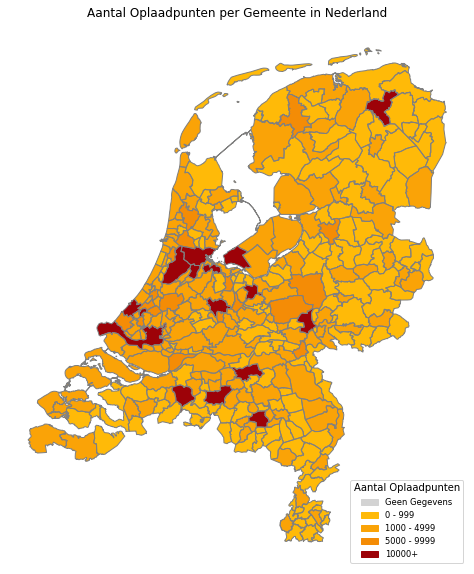

In [104]:
# Gebruik de juiste kolomnaam 'Totaal Aantal (Totaal)' voor het aantal oplaadpunten
charging_points['Category of charging points'] = charging_points['Totaal Aantal (Totaal)'].apply(categorize_charging_points)

# WFS-URL en parameters voor gemeenten
wfs_url = "https://service.pdok.nl/cbs/gebiedsindelingen/2023/wfs/v1_0"
params = dict(service='WFS', version='1.0.0', request='GetFeature', typename='gemeente_gegeneraliseerd', outputFormat='json')
response = requests.get(wfs_url, params=params)

# Laad de gemeentelijke gegevens in een GeoDataFrame
gemeenten_gdf = gpd.read_file(BytesIO(response.content))
gemeenten_gdf.rename(columns={"statnaam": "Municipality"}, inplace=True)

# Merge de gemeentelijke gegevens met de oplaadpunten
merged = gemeenten_gdf.merge(charging_points, left_on="Municipality", right_index=True, how="left")

# Vul NaN-waarden in de 'Totaal Aantal (Totaal)' kolom met 0
merged['Totaal Aantal (Totaal)'].fillna(0, inplace=True)

# Maak de kleurkolom aan op basis van het aantal oplaadpunten
merged['Color'] = pd.cut(merged['Totaal Aantal (Totaal)'],
                         bins=[-1, 0, 999, 4999, 9999, float('inf')],
                         labels=['Geen Gegevens', '0 - 999', '1000 - 4999', '5000 - 9999', '10000+'])

# Kleurenschema voor de legenda
charging_colors = {'Geen Gegevens': 'lightgrey', '0 - 999': '#ffba08', '1000 - 4999': '#faa307',
                   '5000 - 9999': '#f48c06', '10000+': '#9d0208'}

# Plot de grenzen van de gemeenten
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax, linewidth=1, color="grey")

# Plot de kleuren op basis van het aantal oplaadpunten
merged.plot(color=merged["Color"].map(charging_colors), ax=ax,
            missing_kwds={"color": "lightgrey", "label": "Geen Gegevens"})

# Titel en assen verbergen
ax.set_title('Aantal Oplaadpunten per Gemeente in Nederland')
plt.axis('off')  # Verberg de assen

# Legenda
patches = [mpatches.Patch(color=color, label=label) for label, color in charging_colors.items()]
ax.legend(handles=patches, title="Aantal Oplaadpunten", loc='lower right', fontsize='small', title_fontsize='medium')

plt.show()


In [86]:
charging_points = pd.read_excel('paal.xlsx', skiprows=1, index_col=[0])

charging_points = charging_points.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8','Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'])


charging_points = charging_points.drop(index=['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Limburg', 'Noord-Brabant', 'Noord-Holland', 'Overijssel', 'Zeeland', 'Zuid-Holland', 'Eindtotaal'])
charging_points.sort_index(inplace=True)

print(charging_points.columns)

def amount_of_chargingpoints(value):
    if value < 1000:
        level = 'low'
    elif value < 5000:
        level = 'medium'
    elif value < 10000:
        level = 'high'
    else:
        level = 'very high'
    return level
    
charging_points["Category of charging points"] = charging_points["Totaal Aantal (Totaal)"].apply(amount_of_chargingpoints)

charging_points.index = charging_points.index.str.replace("Den Haag", "'s-Gravenhage")

# Verwijder de rij van "Groningen" met 8271 in de kolom "Totaal Aantal (Totaal)"
charging_points = charging_points[~((charging_points.index == 'Groningen') & (charging_points["Totaal Aantal (Totaal)"] == 16472))]


display(charging_points)

Index(['Publiek', 'Semi-publiek', 'Totaal Aantal (Totaal)'], dtype='object')


,Publiek,Semi-publiek,Totaal Aantal (Totaal),Category of charging points
's-Hertogenbosch,6584,5705,12539.0,very high
Aa en Hunze,86,193,279.0,low
Aalsmeer,1933,1161,3094.0,medium
Aalten,332,139,471.0,low
Achtkarspelen,160,71,231.0,low
...,...,...,...,...
Zutphen,1269,759,2033.0,medium
Zwartewaterland,266,614,880.0,low
Zwijndrecht,1296,419,1715.0,medium
Zwolle,4290,4465,9185.0,high


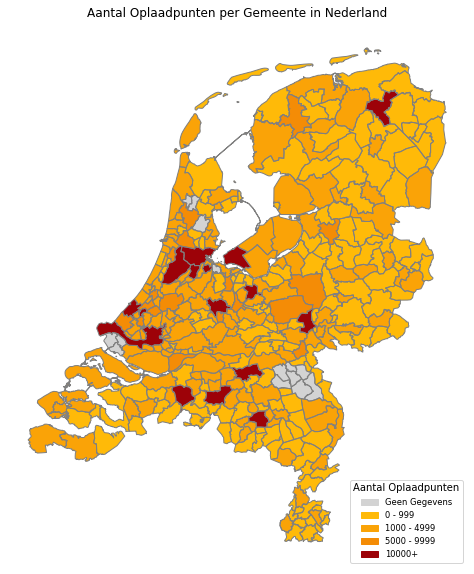

In [88]:
# Gebruik de juiste kolomnaam 'Totaal Aantal (Totaal)' voor het aantal oplaadpunten
charging_points['Category of charging points'] = charging_points['Totaal Aantal (Totaal)'].apply(categorize_charging_points)

# WFS-URL en parameters voor gemeenten
wfs_url = "https://service.pdok.nl/cbs/gebiedsindelingen/2021/wfs/v1_0"
params = dict(service='WFS', version='1.0.0', request='GetFeature', typename='gemeente_gegeneraliseerd', outputFormat='json')
response = requests.get(wfs_url, params=params)

# Laad de gemeentelijke gegevens in een GeoDataFrame
gemeenten_gdf = gpd.read_file(BytesIO(response.content))
gemeenten_gdf.rename(columns={"statnaam": "Municipality"}, inplace=True)

# Merge de gemeentelijke gegevens met de oplaadpunten
merged = gemeenten_gdf.merge(charging_points, left_on="Municipality", right_index=True, how="left")

# Vul NaN-waarden in de 'Totaal Aantal (Totaal)' kolom met 0
merged['Totaal Aantal (Totaal)'].fillna(0, inplace=True)

# Maak de kleurkolom aan op basis van het aantal oplaadpunten
merged['Color'] = pd.cut(merged['Totaal Aantal (Totaal)'],
                         bins=[-1, 0, 999, 4999, 9999, float('inf')],
                         labels=['Geen Gegevens', '0 - 999', '1000 - 4999', '5000 - 9999', '10000+'])

# Kleurenschema voor de legenda
charging_colors = {'Geen Gegevens': 'lightgrey', '0 - 999': '#ffba08', '1000 - 4999': '#faa307',
                   '5000 - 9999': '#f48c06', '10000+': '#9d0208'}

# Plot de grenzen van de gemeenten
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax, linewidth=1, color="grey")

# Plot de kleuren op basis van het aantal oplaadpunten
merged.plot(color=merged["Color"].map(charging_colors), ax=ax,
            missing_kwds={"color": "lightgrey", "label": "Geen Gegevens"})

# Titel en assen verbergen
ax.set_title('Aantal Oplaadpunten per Gemeente in Nederland')
plt.axis('off')  # Verberg de assen

# Legenda
patches = [mpatches.Patch(color=color, label=label) for label, color in charging_colors.items()]
ax.legend(handles=patches, title="Aantal Oplaadpunten", loc='lower right', fontsize='small', title_fontsize='medium')

plt.show()
